## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [159]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

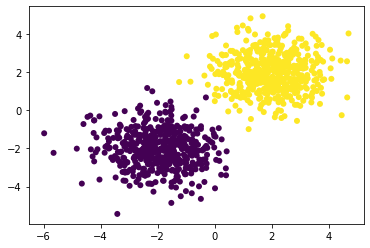

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [204]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [189]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

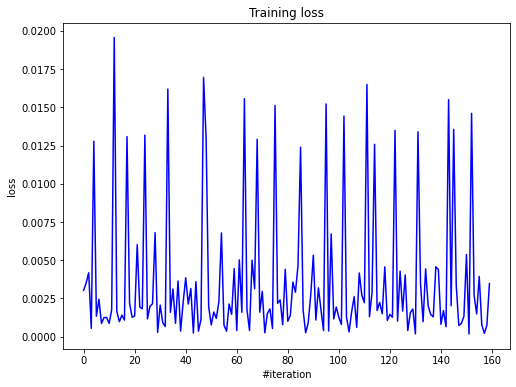

Current loss: 0.003470


In [190]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [191]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [192]:
# Your code goes here. ################################################
classes = y_train.max() + 1
y_train_ohe = np.eye(classes)[y_train]
y_val_ohe = np.eye(classes)[y_val]
y_test_ohe = np.eye(classes)[y_test]

In [193]:
X_train_flatten = X_train.reshape(len(X_train), -1)
X_val_flatten = X_val.reshape(len(X_val), -1)
X_test_flatten = X_test.reshape(len(X_val), -1)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [194]:
image_size = X_test_flatten.shape[1]
image_size, classes

(784, 10)

In [266]:
# Your code goes here. ################################################
net_relu = Sequential()
net_relu.add(Linear(784, 300))
net_relu.add(ReLU())
net_relu.add(Linear(300, 10))
net_relu.add(LogSoftMax())

net_elu = Sequential()
net_elu.add(Linear(784, 300))
net_elu.add(ELU(alpha=0.9))
net_elu.add(Linear(300, 10))
net_elu.add(LogSoftMax())

net_leakrelu = Sequential()
net_leakrelu.add(Linear(784, 300))
net_leakrelu.add(LeakyReLU())
net_leakrelu.add(Linear(300, 10))
net_leakrelu.add(LogSoftMax())

net_softplus = Sequential()
net_softplus.add(Linear(784, 300))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(300, 10))
net_softplus.add(LogSoftMax())

criterion = ClassNLLCriterion()

In [267]:
def train_model(
    net, criterion=criterion, n_epoch=n_epoch, 
    X_train=X_train_flatten, y_train=y_train_ohe, 
    X_val=X_val_flatten, y_val=y_val_ohe,
    optimizer_config={'learning_rate' : 1e-1, 'momentum': 0.9},
    batch_size=128, opimizer=sgd_momentum
):
    measurements = {
        'train_time': 0,
        'loss_history_train': [],
        'loss_history_val': []
    }
    optimizer_state={}
    for i in range(n_epoch):
        time_start_epoch = time()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            # Update weights
            opimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)   
        measurements['train_time'] += time() - time_start_epoch
        predict_train = net.forward(X_train)
        predict_val = net.forward(X_val)
        train_loss = criterion.forward(predict_train, y_train)
        val_loss = criterion.forward(predict_val, y_val)
        measurements['loss_history_train'].append(train_loss)
        measurements['loss_history_val'].append(val_loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(measurements['loss_history_train'], label = 'train')
        plt.plot(measurements['loss_history_val'], label = 'val')
        plt.legend()
        plt.grid(True)
        plt.show()

        print('Current train loss: %f' % train_loss)
        print('Current val loss: %f' % val_loss)

    return measurements

In [288]:
# Your code goes here. ################################################
def accuracy(prediction, label):
    pred = np.argmax(prediction, axis = -1)
    return (pred == label).mean()

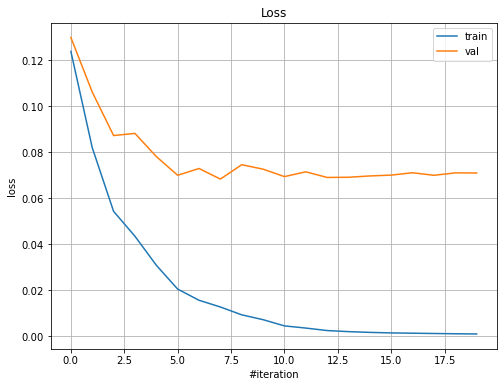

Current train loss: 0.001033
Current val loss: 0.071025


In [268]:
relu_measurements = train_model(net_relu)

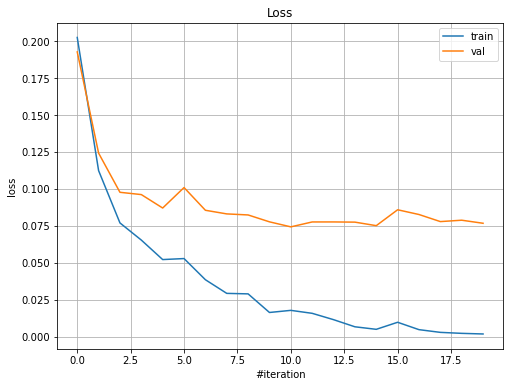

Current train loss: 0.001820
Current val loss: 0.076716


In [270]:
elu_measurements = train_model(net_elu)

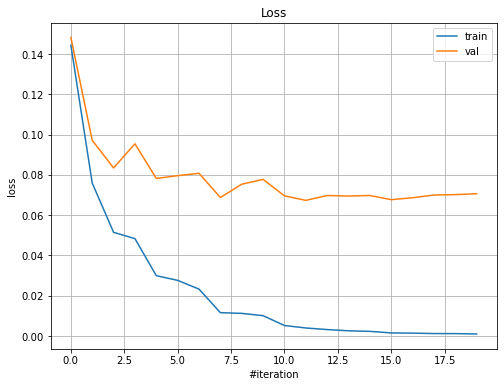

Current train loss: 0.001057
Current val loss: 0.070655


In [272]:
leakrelu_measurements = train_model(net_leakrelu)

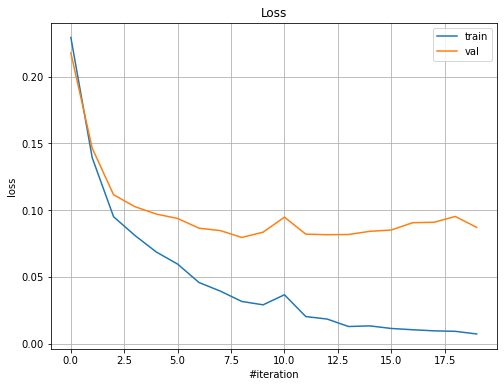

Current train loss: 0.007223
Current val loss: 0.087060


In [273]:
softplus_measurements = train_model(net_softplus)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

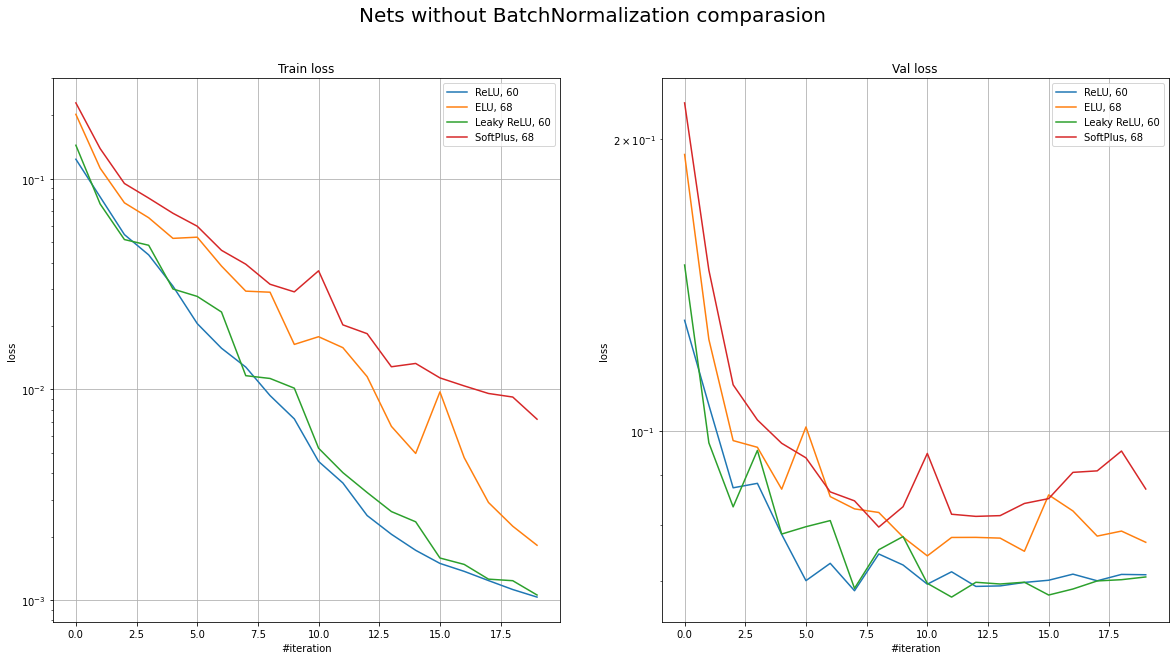

In [274]:
# Your answer goes here. ################################################
f = plt.figure(figsize=(20, 10))
f.suptitle('Nets without BatchNormalization comparasion', fontsize=20)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("Train loss")
ax.set_xlabel("#iteration")
ax.set_ylabel("loss")
ax.semilogy(relu_measurements['loss_history_train'], label = f'ReLU, {round(relu_measurements["train_time"])}')
ax.semilogy(elu_measurements['loss_history_train'], label = f'ELU, {round(elu_measurements["train_time"])}')
ax.semilogy(leakrelu_measurements['loss_history_train'], label = f'Leaky ReLU, {round(leakrelu_measurements["train_time"])}')
ax.semilogy(softplus_measurements['loss_history_train'], label = f'SoftPlus, {round(softplus_measurements["train_time"])}')

ax.grid(True)
ax.legend()

ax2.set_title("Val loss")
ax2.set_xlabel("#iteration")
ax2.set_ylabel("loss")
ax2.semilogy(relu_measurements['loss_history_val'], label = f'ReLU, {round(relu_measurements["train_time"])}')
ax2.semilogy(elu_measurements['loss_history_val'], label = f'ELU, {round(elu_measurements["train_time"])}')
ax2.semilogy(leakrelu_measurements['loss_history_val'], label = f'Leaky ReLU, {round(leakrelu_measurements["train_time"])}')
ax2.semilogy(softplus_measurements['loss_history_val'], label = f'SoftPlus, {round(softplus_measurements["train_time"])}')

ax2.grid(True)
ax2.legend()

From the plots above we can conclude, that SoftPlus is worst activation function on both metric time and loss. ReLU and Leaky ReLU have the same perfomance, but ReLU is faster. LeakyReLU and ReLU outperform ELU. So, in the feature we will use only ReLU.

In [275]:
# Your code goes here. ################################################
net_relu_batch = Sequential()
net_relu_batch.add(Linear(784, 300))
net_relu_batch.add(BatchNormalization())
net_relu_batch.add(ChannelwiseScaling(300))
net_relu_batch.add(ReLU())
net_relu_batch.add(Linear(300, 10))
net_relu_batch.add(BatchNormalization())
net_relu_batch.add(ChannelwiseScaling(10))
net_relu_batch.add(LogSoftMax())

criterion = ClassNLLCriterion()

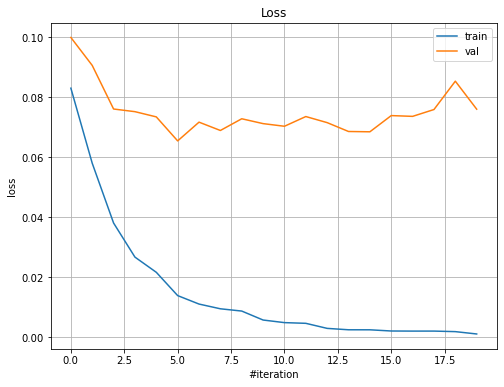

Current train loss: 0.001020
Current val loss: 0.075974


In [276]:
relu_batch_measurements = train_model(net_relu_batch)

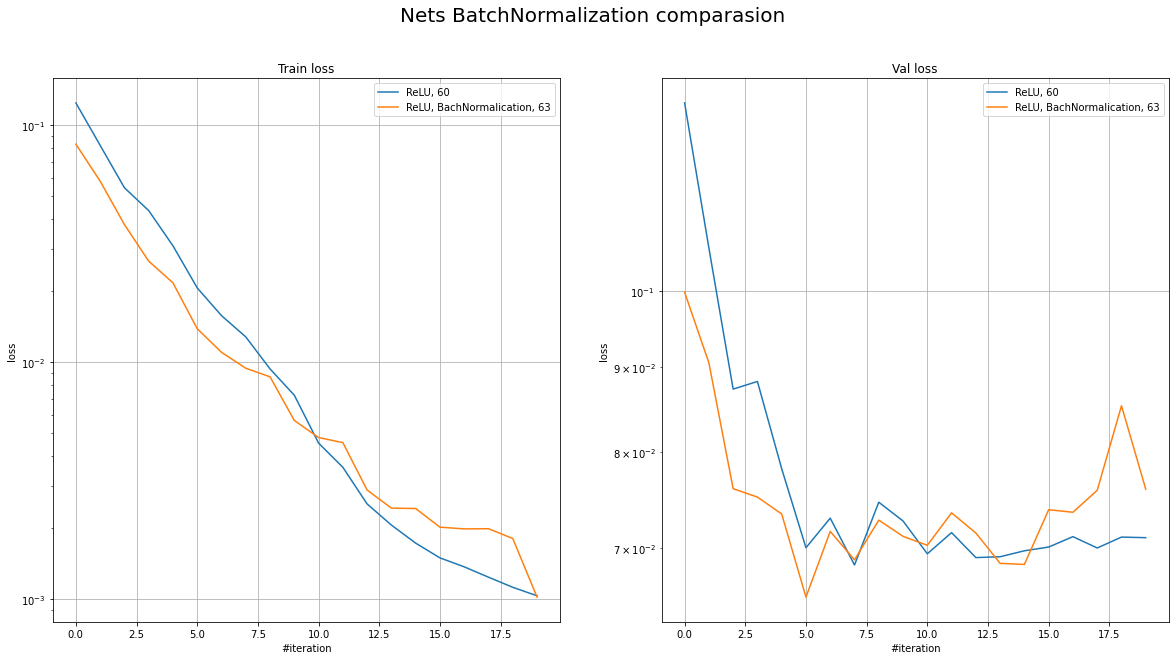

In [277]:
# Your answer goes here. ################################################
f = plt.figure(figsize=(20, 10))
f.suptitle('Nets BatchNormalization comparasion', fontsize=20)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("Train loss")
ax.set_xlabel("#iteration")
ax.set_ylabel("loss")
ax.semilogy(relu_measurements['loss_history_train'], label = f'ReLU, {round(relu_measurements["train_time"])}')
ax.semilogy(relu_batch_measurements['loss_history_train'], label = f'ReLU, BachNormalication, {round(relu_batch_measurements["train_time"])}')

ax.grid(True)
ax.legend()

ax2.set_title("Val loss")
ax2.set_xlabel("#iteration")
ax2.set_ylabel("loss")
ax2.semilogy(relu_measurements['loss_history_val'], label = f'ReLU, {round(relu_measurements["train_time"])}')
ax2.semilogy(relu_batch_measurements['loss_history_val'], label = f'ReLU, BachNormalication, {round(relu_batch_measurements["train_time"])}')

ax2.grid(True)
ax2.legend()

BatchNormalization slightly increase performance and doesn't requires a lot of time. **However I have a question: Should we add BatchNormalization before SoftMax, from my point of view not, if this case performance is much lower**

In [278]:
net_relu_batch_adam = Sequential()
net_relu_batch_adam.add(Linear(784, 300))
net_relu_batch_adam.add(BatchNormalization())
net_relu_batch_adam.add(ChannelwiseScaling(300))
net_relu_batch_adam.add(ReLU())
net_relu_batch_adam.add(Linear(300, 10))
net_relu_batch_adam.add(BatchNormalization())
net_relu_batch_adam.add(ChannelwiseScaling(10))
net_relu_batch_adam.add(LogSoftMax())

criterion = ClassNLLCriterion()
adam_parameters = dict(learning_rate=1e-1, beta1=0.9, beta2=0.999, epsilon=1e-8)

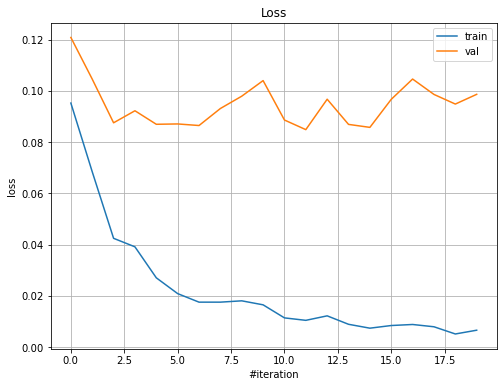

Current train loss: 0.006563
Current val loss: 0.098618


In [279]:
relu_batch_adam_measurements = train_model(net_relu_batch_adam, opimizer=adam_optimizer, optimizer_config=adam_parameters)

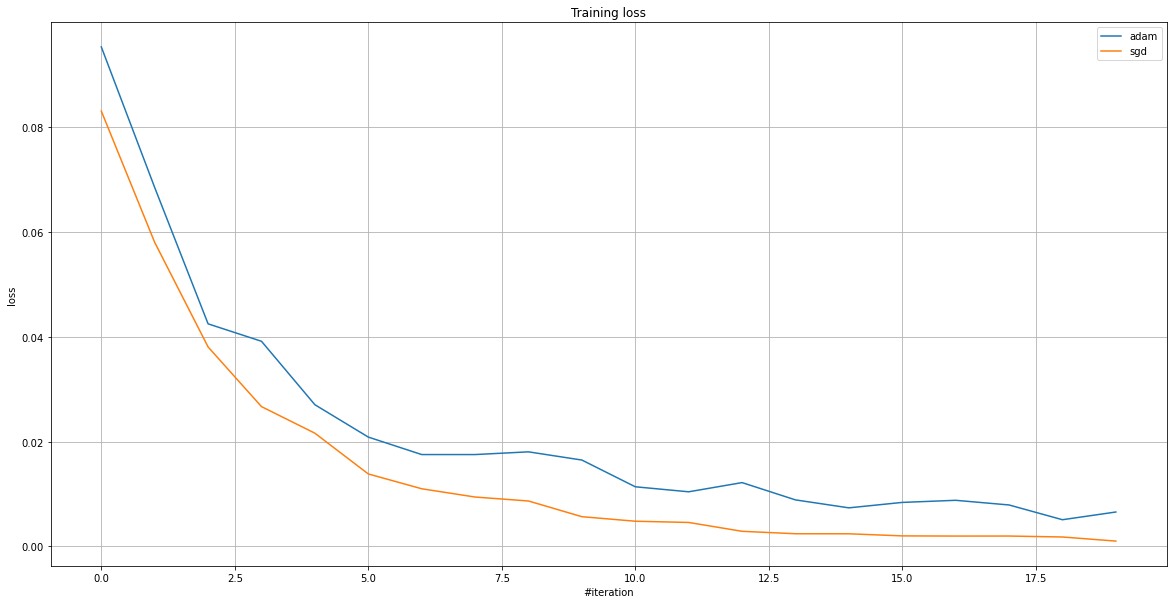

In [280]:
plt.figure(figsize=(20, 10))
plt.plot(relu_batch_adam_measurements['loss_history_train'], label='adam')
plt.plot(relu_batch_measurements['loss_history_train'], label='sgd')
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

Despite the fact that SGD converges better we will use ADAM, probably we just have to tune it

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [309]:
final_model = Sequential()
final_model.add(Linear(784, 300))
final_model.add(BatchNormalization())
final_model.add(ChannelwiseScaling(300))
final_model.add(ReLU())
final_model.add(Dropout())
final_model.add(Linear(300, 64))
final_model.add(BatchNormalization())
final_model.add(ChannelwiseScaling(64))
final_model.add(ReLU())
final_model.add(Dropout())
final_model.add(Linear(64, 10))
final_model.add(LogSoftMax())

adam_parameters = dict(learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8)

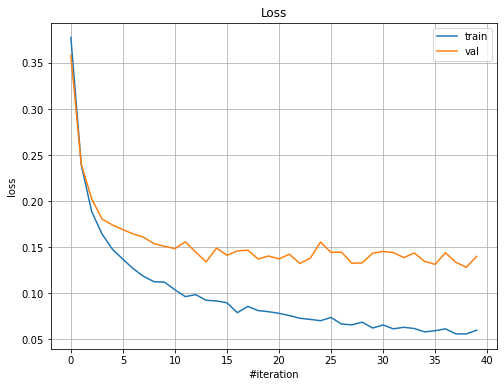

Current train loss: 0.059965
Current val loss: 0.140013


In [310]:
final_model_measurements = train_model(final_model, n_epoch=40, opimizer=adam_optimizer, optimizer_config=adam_parameters)

In [311]:
final_model.evaluate()
print(f'accuracy val: {accuracy(final_model.forward(X_val_flatten), y_val)}')

accuracy val: 0.9811


Print here your accuracy on test set. It should be around 90%.

In [312]:
# Your answer goes here. ################################################
final_model.evaluate()
print(f'accuracy: {accuracy(final_model.forward(X_test_flatten), y_test)}')

accuracy: 0.9803


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [317]:
# Your beautiful code here.
import torch
import torch.nn as nn

In [318]:
model = nn.Sequential(nn.Linear(784, 300),
                      nn.BatchNorm1d(300),
                      nn.ReLU(),
                      nn.Dropout(),
                      nn.Linear(300, 64),
                      nn.BatchNorm1d(64),
                      nn.ReLU(),
                      nn.Dropout(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax())

In [337]:
adam_parameters_torch = dict(
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08
)

In [338]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), **adam_parameters_torch)

In [339]:
X_train_flatten_torch = torch.tensor(X_train_flatten)
y_train_torch = torch.tensor(y_train)

In [340]:
losses = []
for epoch in range(40):
    pred_y = model(X_train_flatten_torch)
    loss = criterion(pred_y, y_train_torch)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


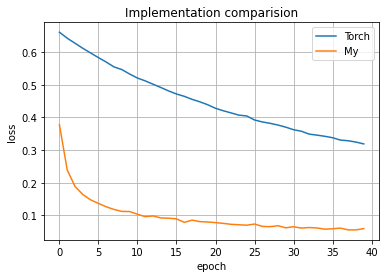

In [341]:
import matplotlib.pyplot as plt
plt.plot(losses, label='Torch')
plt.plot(final_model_measurements['loss_history_train'], label='My')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Implementation comparision")
plt.legend()
plt.grid(True)

In [342]:
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=300, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=64, out_features=10, bias=True)
  (9): LogSoftmax(dim=None)
)

In [343]:
pred = model(torch.torch.tensor(X_val_flatten))

/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [348]:
accuracy(pred.detach().numpy(), y_val)

0.9633

**Question: why my implementation is better?**